<a href="https://colab.research.google.com/github/develop-veve/git_study/blob/master/%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##利用するライブラリのインポート

In [2]:
import torch
import torch.nn as nn  # ニューラルネットワーク関連のクラス
import torch.optim as optim  # 最適化アルゴリズム
import matplotlib.pyplot as plt  # グラフ描画ライブラリ
import numpy as np  # 数値計算ライブラリ

## matplotlib の設定

In [3]:
# 通常、matplotlib.pyplot を使ってグラフを描画すると、plt.show() を呼び出さないと表示されません。
# しかし、%matplotlib inline を設定すると、グラフがセルの出力として自動的に表示 されるようになります。
%matplotlib inline

# このコマンドは Matplotlib のスタイルを ggplot に変更する ためのものです。
# ggplot は、R 言語の ggplot2 ライブラリに似たデザインのスタイルで、赤系のグリッド背景と見やすいカラーパレット が特徴です。
# Matplotlib には複数のプリセットのスタイルが用意されており、plt.style.use() を使うことで簡単に適用できます。
plt.style.use("ggplot")

## Pytorch の乱数作成時の固定化

In [4]:
# データの生成　乱数を固定生成
# 乱数生成のパターンを固定する」 だけであり、乱数を 具体的に生成しているわけではない。
torch.manual_seed(123)

# ランダムなテンソルを生成
# このロジックは、具体的に配列に３つ、乱数を生成した。
print(torch.rand(3))

tensor([0.2961, 0.5166, 0.2517])


## 0 から 5 までの値を等間隔に 100 個生成
- linspace を使用して、範囲 [0,5] の間に 100 個の値を均等に生成する
- view(100,1) によって、100行1列の形状に変換している

In [5]:
# 0 から 5 までの値を 等間隔 に 100個 生成
x = torch.linspace(0, 5, 100).view(100, 1)

## 値の確認

In [6]:
print(x[:10])   # 10までの行列を確認
print(x.shape)  # サイズを確認

tensor([[0.0000],
        [0.0505],
        [0.1010],
        [0.1515],
        [0.2020],
        [0.2525],
        [0.3030],
        [0.3535],
        [0.4040],
        [0.4545]])
torch.Size([100, 1])


## $x$ と $y$ をプロット
✅ 「プロットの目的」を補足 → まずはノイズなしの直線を確認する。

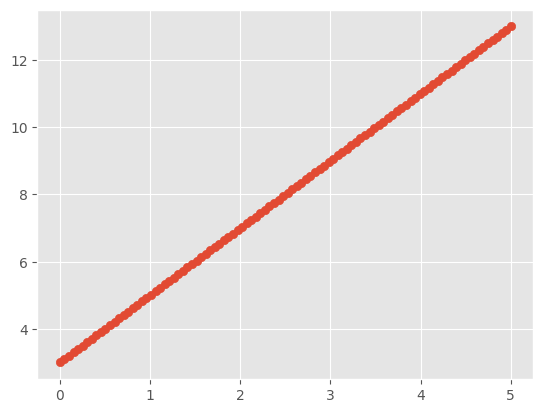

In [7]:
# ノイズなしの直線データ
a = 2  # 傾き
b = 3  # 切片
y = a * x + b  # 直線 y = 2x + 3
plt.scatter(x, y)

## $x$ と $y$ をプロット（乱数値で値をばらつかせる）
✅ 「なぜノイズを加えるのか」を補足 → 実際のデータは完全な直線ではないため、ノイズを加えてより現実的なデータにする。

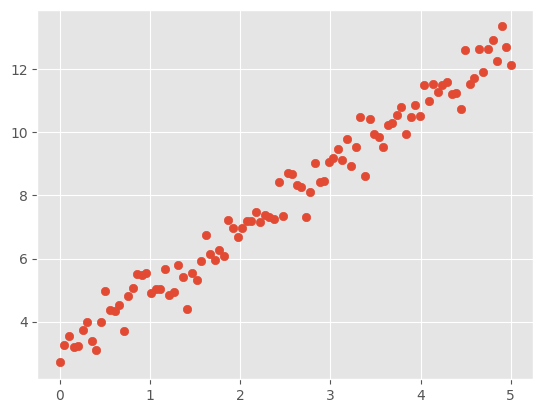

In [8]:
# 単回帰に良さそうな分布のデータにする
eps = torch.randn(100, 1) * 0.5  #ノイズの強さを調整
y = a*x + b + eps
plt.scatter(x, y)

## 線形回帰モデルの定義
✅ 「順伝播（forward）の説明」を補足 → x を入力して線形変換を適用し、予測値を出力する。

In [9]:
# -------------------------------------------------
# 線形回帰モデルの定義（PyTorchの nn.Module を継承）
# -------------------------------------------------
class MyLinearRegression(nn.Module):

    def __init__(self):

         # nn.Module の初期化（重要：これを呼ばないとエラーになる）
        super().__init__()

        # 線形変換 y = Wx + b を定義
        self.linear = nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        """
        順伝播（推論処理）
        入力 x に対して線形変換を適用し、出力を返す。
        """
         # 線形変換を適用
        output = self.linear(x)

         # 返却
        return output

## 1. モデルの作成とテスト
✅ モデルの作成

In [10]:
# 線形回帰モデルを生成
model = MyLinearRegression()

✅ モデルが適切に動作するか確認

In [11]:
# モデルにサンプルデータを入力し、出力を確認
x_test = torch.tensor([[1.0], [2.0]])
model(x_test)

tensor([[0.5436],
        [1.3985]], grad_fn=<AddmmBackward0>)

## 2. 予測用データの作成

✅ 学習データの範囲と一致するように、予測用データを作成

In [12]:
x2 = torch.linspace(0, 3, 100).view(100, 1)
x2.size()

torch.Size([100, 1])

✅ モデルの予測結果を取得

In [13]:
y_pred = model(x2)

## 3. 予測結果の可視化
✅ データと予測値を比較して、モデルの初期状態を確認

📌 問題点:予測直線が学習データと一致していない → 学習がまだされていない状態

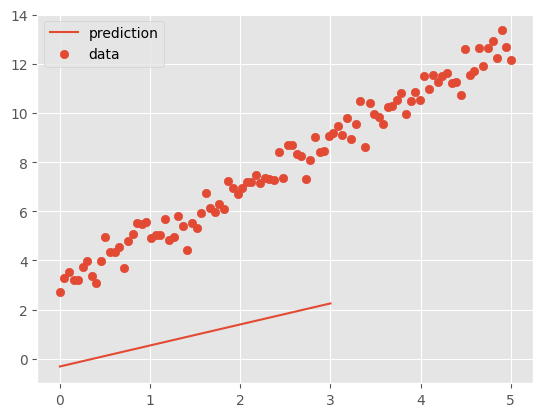

In [14]:
plt.plot(x2, y_pred.detach(), label="prediction")
plt.scatter(x, y, label="data")
plt.legend()

## 4. 損失関数と最適化の設定

✅ MSE を損失関数に、SGD を最適化アルゴリズムに選択

In [20]:
# 損失関数を平均二乗誤差 (MSE) に設定
criterion = nn.MSELoss()

# 最適化アルゴリズムを SGD（確率的勾配降下法）に設定
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 5. モデルの学習

✅ 損失を計算し、パラメータを更新して学習を進める

📌 損失が徐々に減少していることを確認

In [16]:
losses = []
num_epoch = 500
for epoch in range(num_epoch):

    # 勾配の初期化
    optimizer.zero_grad()

    # モデルの予測値を取得
    y_pred = model(x)

    # 損失関数の計算
    loss = criterion(y_pred, y)

    # 逆伝播
    loss.backward()

    # パラメータの更新
    optimizer.step()

    # 現状表示
    if epoch % 50  == 0:
        print("epoch:{}, loss:{}".format(epoch, loss.item()))

    # 損失を保存
    losses.append(loss.item())

epoch:0, loss:39.91118240356445
epoch:50, loss:1.4142757654190063
epoch:100, loss:0.965803861618042
epoch:150, loss:0.6843885779380798
epoch:200, loss:0.5078012943267822
epoch:250, loss:0.3969932198524475
epoch:300, loss:0.32746121287345886
epoch:350, loss:0.28383007645606995
epoch:400, loss:0.25645163655281067
epoch:450, loss:0.23927181959152222


## 6. 学習過程の可視化

✅ 学習が進むにつれて損失が減少することを確認

📌 このグラフで、学習が適切に行われているかを視覚的に確認できる

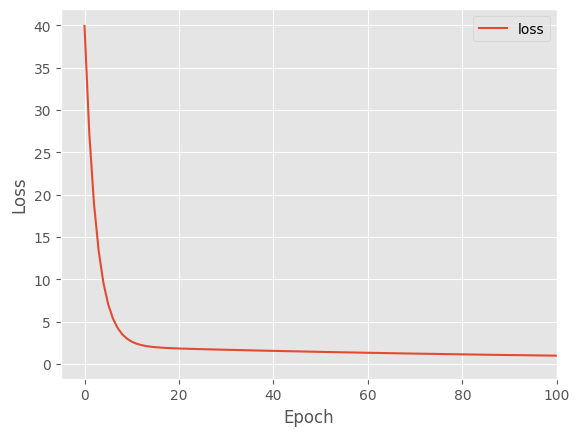

In [17]:
# 損失値の処理毎の変化をグラフ表示
plt.plot(losses, label="loss")  # lossのプロット
plt.xlim(-5, 100)               # X軸の範囲を0から100に制限
plt.xlabel("Epoch")             # X軸のラベル
plt.ylabel("Loss")              # Y軸のラベル
plt.legend()                    # 凡例を表示
plt.grid(True)                  # グリッドを表示
plt.show()                      # グラフを描画

## 7. 学習後のモデルの予測

✅ 学習前と比べて予測直線がデータにフィットしているか確認

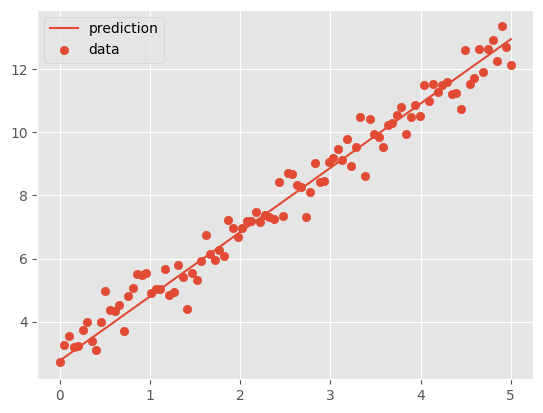

In [18]:
xt = torch.linspace(0, 5, 100).view(100, 1)
yt = model(xt)
plt.plot(xt, yt.detach(), label="prediction")
plt.scatter(x, y, label="data")
plt.legend()

## 8. 最終確認

✅ 予測直線が元データにフィットしている（学習が進んでいる）

✅ W ≈ 2、b ≈ 3 に近い値になっている（学習が成功している）

✅ MSE が小さくなっている（誤差が減少している）

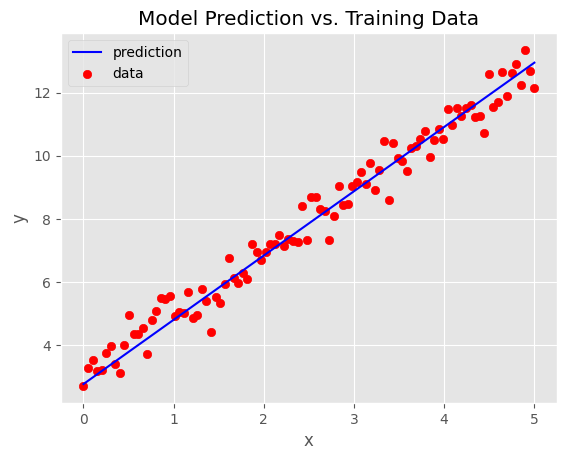

Learned Weight (W): 2.0370941162109375
Learned Bias (b): 2.7644524574279785
Mean Squared Error (MSE): 0.22849145531654358


In [22]:
import torch
import matplotlib.pyplot as plt

# 学習済みのモデルを使って予測
xt = torch.linspace(0, 5, 100).view(100, 1)  # 0から5までのデータを100個作成
yt = model(xt)  # 学習済みモデルに入力して予測値を取得

# 予測結果と実データの可視化
plt.plot(xt, yt.detach(), label="prediction", color="blue")  # 予測直線を描画
plt.scatter(x, y, label="data", color="red")  # 元データの散布図
plt.legend()  # 凡例を表示
plt.xlabel("x")  # x軸のラベル
plt.ylabel("y")  # y軸のラベル
plt.title("Model Prediction vs. Training Data")  # タイトルを設定
plt.grid(True)  # グリッド表示
plt.show()  # グラフを表示

# モデルのパラメータを確認
print("Learned Weight (W):", model.linear.weight.item())
print("Learned Bias (b):", model.linear.bias.item())

# 予測誤差の確認
y_pred = model(x)  # 学習データに対する予測値
error = y - y_pred  # 誤差計算
mse = torch.mean(error**2).item()  # 平均二乗誤差（MSE）
print("Mean Squared Error (MSE):", mse)



✅ モデルは、学習前は適切にデータを予測できなかったが、学習後には データにフィットした直線 を描けるようになった

✅ 損失関数の値が減少しており、学習が正しく進んでいる

✅ 線形回帰の基本的な学習プロセスを実装できた